# Regularized least squares - bounds and smoothness
#### Computational Methods for Geoscience - EPS 400/522
#### Instructor: Eric Lindsey

---------

In [4]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats

import fault_model

%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens
# automatically reload modules when running, otherwise jupyter does not notice if our functions have changed
%load_ext autoreload
%autoreload 2


## Example - Line fitting

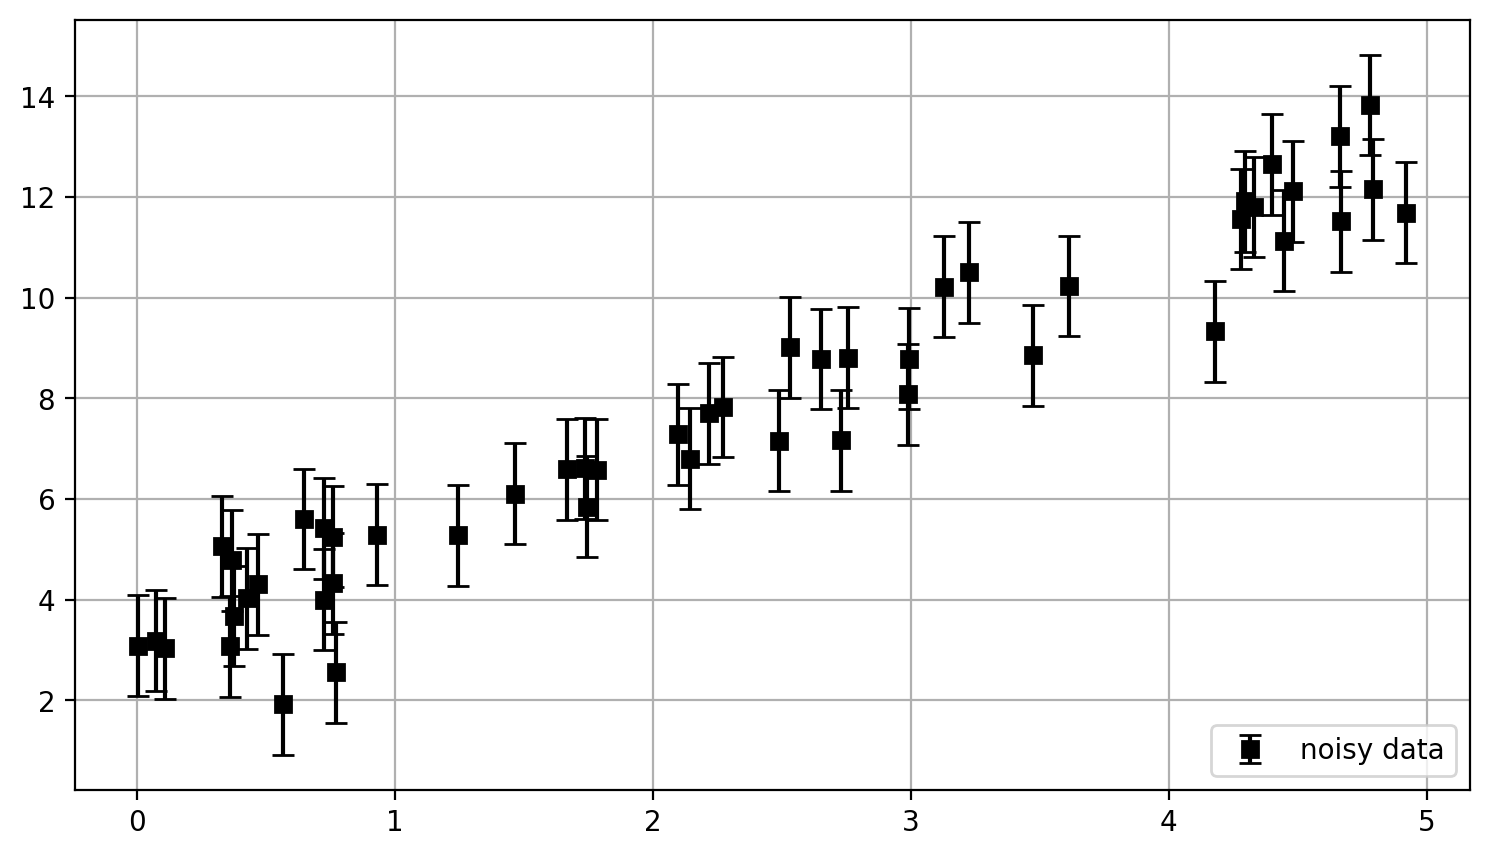

In [5]:
# create some test data that follows a line

# True parameter values
a_true = 2
b_true = 3
sigma = 1

# Size of dataset
size = 50

# Predictor variable ("independent variable", or in geophysics, "coordinates")
x = 5*np.random.rand(size)

# Simulate outcome (dependent variable)
y = a_true*x + b_true + np.random.normal(size=size) * sigma

# simulate y errors
yerr = sigma*np.ones(size)

# plot the simulated data
plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=sigma,fmt='ks',label='noisy data',capsize=4)
plt.legend(loc='lower right')
plt.grid()
plt.show()


Since this is a 2-parameter, linear model, it's great for testing that our code is working, since we can benchmark it against the least squares solution. 

Benchmarking is always a good idea - don't try out your code on new data until you know for sure it works correctly!

### Solution 1. Least-squares analysis

1.9568771574454056 3.067368725627322


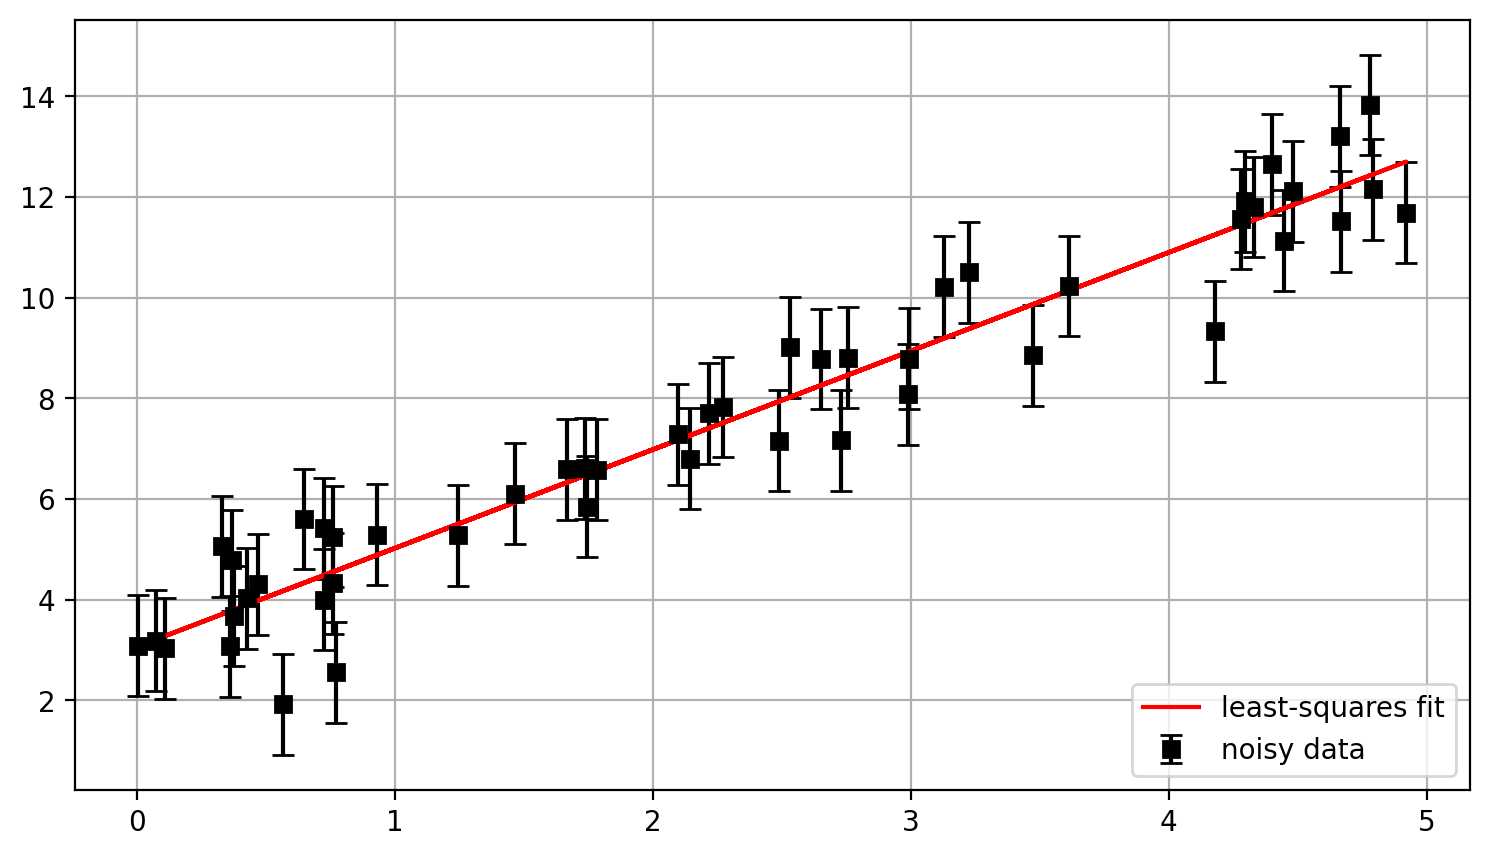

In [6]:
# scipy.stats package for linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
print(slope,intercept)
# plot the best-fit line
lsq_model = slope*x + intercept

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=sigma,fmt='ks',label='noisy data',capsize=4)
plt.plot(x,lsq_model, '-r', label='least-squares fit')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [7]:
# Another method: use Scipy least squares - we need to define our "G" matrix to use this
G = np.column_stack( (x, 0*x+1) )
m = scipy.optimize.lsq_linear(G,y)

# the model output contains lots of info:
print(m)

# the model parameters are in "m.x"
print("\nSolution:")
print(m.x)

# compare to the values from linregress - should be equal to floating point error
print("\nDifference from scipy.stats.linregress:")
print(m.x[0]-slope, m.x[1]-intercept)

       message: The unconstrained solution is optimal.
       success: True
        status: 3
           fun: [ 1.920e+00  6.468e-01 ...  6.906e-01 -2.878e-02]
             x: [ 1.957e+00  3.067e+00]
           nit: 0
          cost: 17.295029620845998
    optimality: 4.2749137563191653e-13
   active_mask: [ 0.000e+00  0.000e+00]
 unbounded_sol: (array([ 1.957e+00,  3.067e+00]), array([ 3.459e+01]), 2, array([ 2.046e+01,  3.875e+00]))

Solution:
[1.95687716 3.06736873]

Difference from scipy.stats.linregress:
8.881784197001252e-16 4.440892098500626e-16


## Bounded least squares

Solution:
[1.         5.14638263]


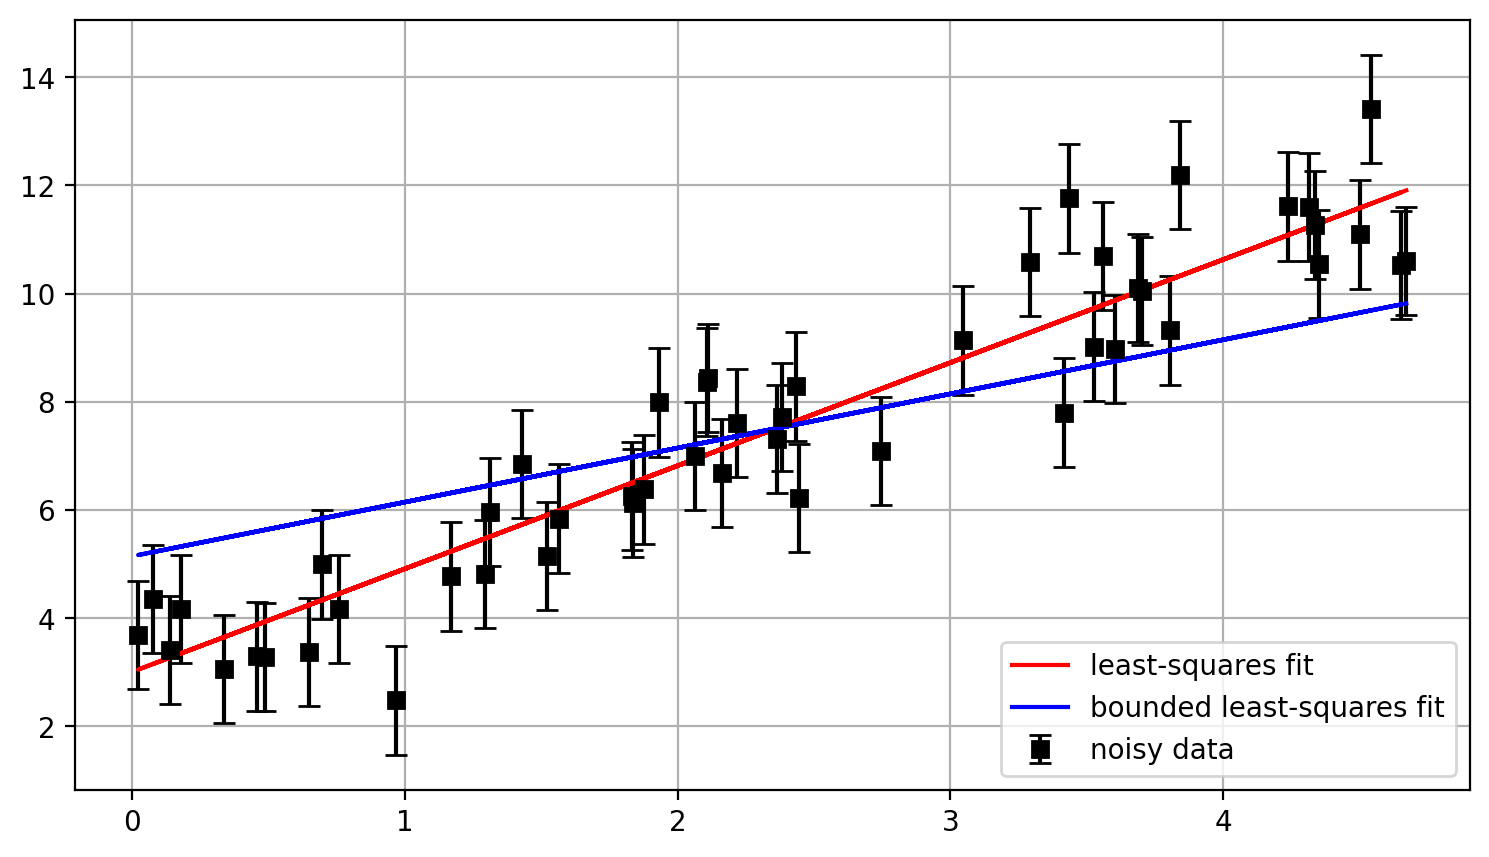

       message: The first-order optimality measure is less than `tol`.
       success: True
        status: 1
           fun: [-7.835e-01  1.481e+00 ...  1.627e+00  2.423e+00]
             x: [ 1.000e+00  5.146e+00]
           nit: 8
          cost: 64.47471396521084
    optimality: 6.170723093342248e-14
   active_mask: [1 0]
 unbounded_sol: (array([ 1.905e+00,  3.010e+00]), array([ 4.705e+01]), 2, array([ 2.042e+01,  3.464e+00]))


In [5]:
# place bounds that the slope is between 0 and 1, and the intercept is between 0 and 10.
m = scipy.optimize.lsq_linear(G,y,bounds=([0,0],[1,10]))

# the model parameters are in "m.x"
print("Solution:")
print(m.x)

# plot this new solution and the original one

bounded_lsq_model = m.x[0]*x + m.x[1]

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=sigma,fmt='ks',label='noisy data',capsize=4)
plt.plot(x,lsq_model, '-r', label='least-squares fit')
plt.plot(x,bounded_lsq_model, '-b', label='bounded least-squares fit')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# note, printing out m reveals that it also knows the unbounded solution:
print(m)

## Setting up a 2D fault model

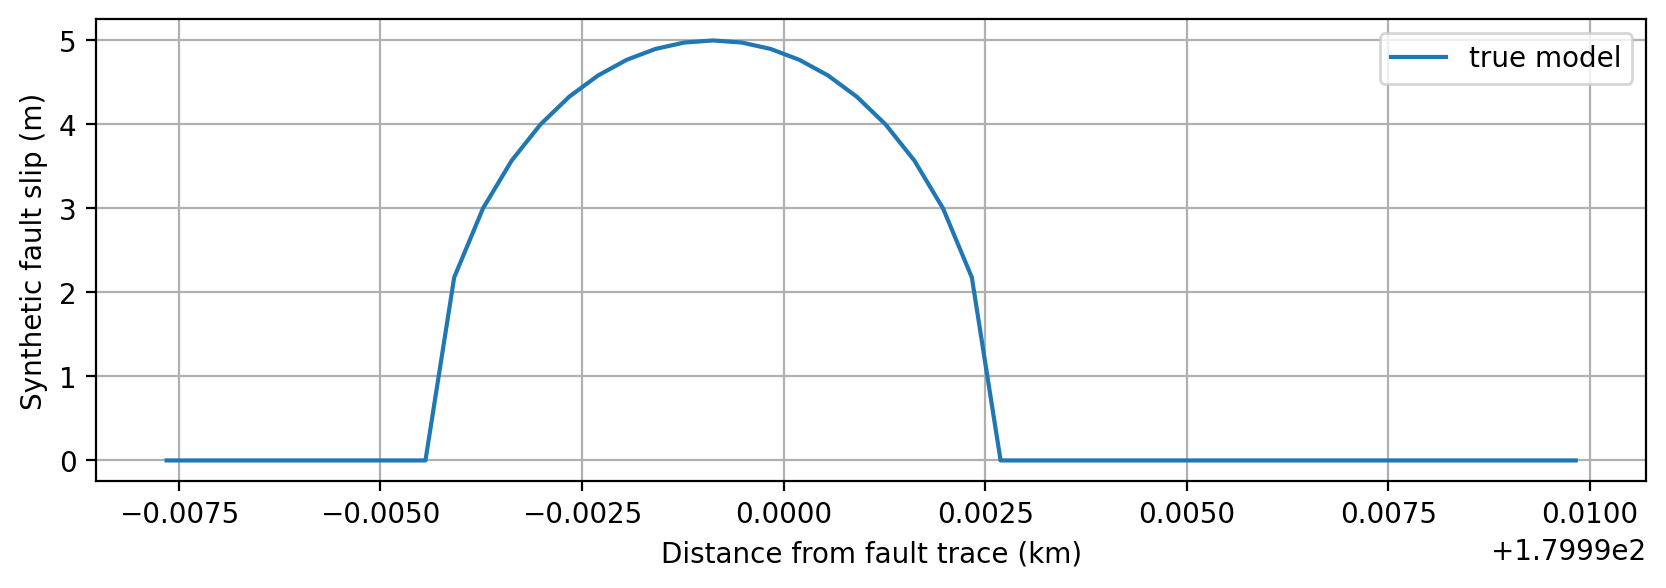

TypeError: FaultModel.get_greens() got an unexpected keyword argument 'coords'

In [11]:
# create an example 2D fault model and create a synthetic earthquake

x0 = 0
y0 = -5e8 # half of the along-strike width so the long fault is centered at zero in the y direction
z0 = 0
strike = 0 # relative to north
dip = 10
L = 1e9 # very long, to simulate a 2D fault
W = 100e3 # 100 km width down-dip
Npatches = 50 # how many fault patches down-dip

# create the model
Fmod=fault_model.FaultModel()
Fmod.create_planar_model(latcorner=y0,loncorner=x0,depthcorner=z0,strike=strike,dip=dip,L=L,W=W,nL=1,nW=Npatches)

# get the patch-center coordinates
patchx = Fmod.lonc
patchy = Fmod.latc
patchz = Fmod.depth

# this is our synthetic fault slip
dip_slip = np.zeros(Npatches) # positive means thrust
for i in range(Npatches):
    # assign slip in an elliptical pattern along-dip
    slipmag = 5
    slipcenter = 30
    slipwidth = 10
    dip_slip[i] = slipmag * np.sqrt(max(0, 1-(i-slipcenter)**2/slipwidth**2))

plt.figure(figsize=(10,3))
plt.plot(patchx,dip_slip,label='true model')
plt.xlabel('Distance from fault trace (km)')
plt.ylabel('Synthetic fault slip (m)')
plt.legend()
plt.grid()
plt.show()

# define some GPS stations
gpsx = np.linspace(-10e3, 150e3, 40)
gpsy = 0*gpsx

# get the Green's functions ("G" matrix) for our fault and particular GPS site locations
G=Fmod.get_greens(gpsy,gpsx,coords='cartesian')

# keep only the dip components
G=G[:,1::2]


# predict GPS displacements with d=G*m
predicted_displacements = np.matmul(G,dip_slip)

# get the E, N, U components
pred_E = predicted_displacements[0::3]
pred_N = predicted_displacements[1::3]
pred_U = predicted_displacements[2::3]

noiseamp=0.1
noisydata = predicted_displacements + noiseamp * np.random.randn(len(predicted_displacements))

# get the E, N, U components
data_E = noisydata[0::3]
data_N = noisydata[1::3]
data_U = noisydata[2::3]

plt.figure(figsize=(10,5))
plt.plot(gpsx,pred_E,'-c',label='East (no noise)')
plt.plot(gpsx,pred_N,'-m',label='North (no noise)')
plt.plot(gpsx,pred_U,'-k',label='Up (no noise)')
plt.plot(gpsx,data_E,'b.',label='East with noise')
plt.plot(gpsx,data_N,'r.',label='North with noise')
plt.plot(gpsx,data_U,'g.',label='Up with noise')

plt.xlabel('Distance from fault trace (km)')
plt.ylabel('Displacement (m)')
plt.legend(loc='upper right')
plt.grid()
plt.show()


# Fit the model in the simplest way
mfit = scipy.optimize.lsq_linear(G,noisydata)


# plot the synthetic model slip
plt.figure(figsize=(10,5))
plt.plot(patchx,mfit.x,label='estimated')
plt.plot(patchx,dip_slip,label='true model')
plt.xlabel('Distance from fault trace (km)')
plt.ylabel('Fault slip (m)')
plt.grid()
plt.legend()
plt.show()

# plot the fit to the data
data_fit = np.matmul(G,mfit.x)

plt.figure(figsize=(10,5))
plt.plot(gpsx,data_E,'b.',label='East')
plt.plot(gpsx,data_N,'r.',label='North')
plt.plot(gpsx,data_U,'g.',label='Up')
plt.plot(gpsx,data_fit[0::3],'-c',label='East fit')
plt.plot(gpsx,data_fit[1::3],'-m',label='North fit')
plt.plot(gpsx,data_fit[2::3],'-k',label='Up fit')
plt.xlabel('Distance from fault trace (km)')
plt.ylabel('Displacement (m)')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [10]:
# the above fits the data perfectly, but the model makes no sense... Let's try adding bounds:

model_min = np.zeros(Npatches)
model_max = 100*np.ones(Npatches)

mfit_bounds = scipy.optimize.lsq_linear(G,noisydata,bounds = (model_min,model_max))

# plot the synthetic model slip
plt.figure(figsize=(10,5))
plt.plot(patchx,mfit_bounds.x,label='estimated')
plt.plot(patchx,dip_slip,label='true model')
plt.xlabel('Distance from fault trace (km)')
plt.ylabel('Fault slip (m)')
plt.grid()
plt.legend()
plt.show()

# plot the fit to the data
data_fit = np.matmul(G,mfit_bounds.x)

plt.figure(figsize=(10,5))
plt.plot(gpsx,data_E,'b.',label='East')
plt.plot(gpsx,data_N,'r.',label='North')
plt.plot(gpsx,data_U,'g.',label='Up')
plt.plot(gpsx,data_fit[0::3],'-c',label='East fit')
plt.plot(gpsx,data_fit[1::3],'-m',label='North fit')
plt.plot(gpsx,data_fit[2::3],'-k',label='Up fit')
plt.xlabel('Distance from fault trace (km)')
plt.ylabel('Displacement (m)')
plt.legend(loc='upper right')
plt.grid()
plt.show()


NameError: name 'noisydata' is not defined

## Smoothed least squares

In [6]:
# To add smoothing, we need to define a Laplacian matrix that, when multiplied by m,
# computes the smoothness (or roughness) of a model. This is usually just the 2nd order
# finite difference operator (https://en.wikipedia.org/wiki/Finite_difference).

# For one dimension, where each model parameter is next to its neighbor, 
# the Laplacian can be represented as:

# L = [ -1   2  -1   0  ...       0 ]
#     [ -1   2  -1   0  ...       0 ]
#     [  0  -1   2  -1  0  ...    0 ]
#     [  0   0  -1   2  -1  0 ... 0 ]
#       ...
#     [ 0  ...     0  -1   2  -1   0 ]
#     [ 0    ...       0  -1   2  -1 ]
#     [ 0    ...       0  -1   2  -1 ]

# note that the first and last rows are repeated, this is not a mistake, 
# it's just how the definition works for the edge cases.

# here is a function that implements this:
import numpy as np

def create_1d_laplacian(size):
    """
    Create a Laplacian matrix of size n x n for one-dimensional data.

    Parameters:
    n (int): The size of the matrix (number of parameters in the model).

    Returns:
    numpy.ndarray: The Laplacian matrix.
    """
    # Initialize an n x n matrix with zeros
    L = np.zeros((size, size))

    # Fill the diagonal with 2s
    np.fill_diagonal(L, 2)

    # Fill the off-diagonals with -1s
    np.fill_diagonal(L[1:], -1)
    np.fill_diagonal(L[:, 1:], -1)

    # Adjust the first and last rows
    L[0, 0:3] = [-1, 2, -1]
    L[-1, -4:-1] = [-1, 2, -1]

    return L

# Example of creating a Laplacian matrix for n = 8
n = 8
L = create_1d_laplacian(n)
print(L)


[[-1.  2. -1.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  2. -1.  2.]]


G shape: (120, 50)
L shape: (50, 50)
G_aug shape: (170, 50)
Data shape: (120,)
Data_aug shape: (170,)


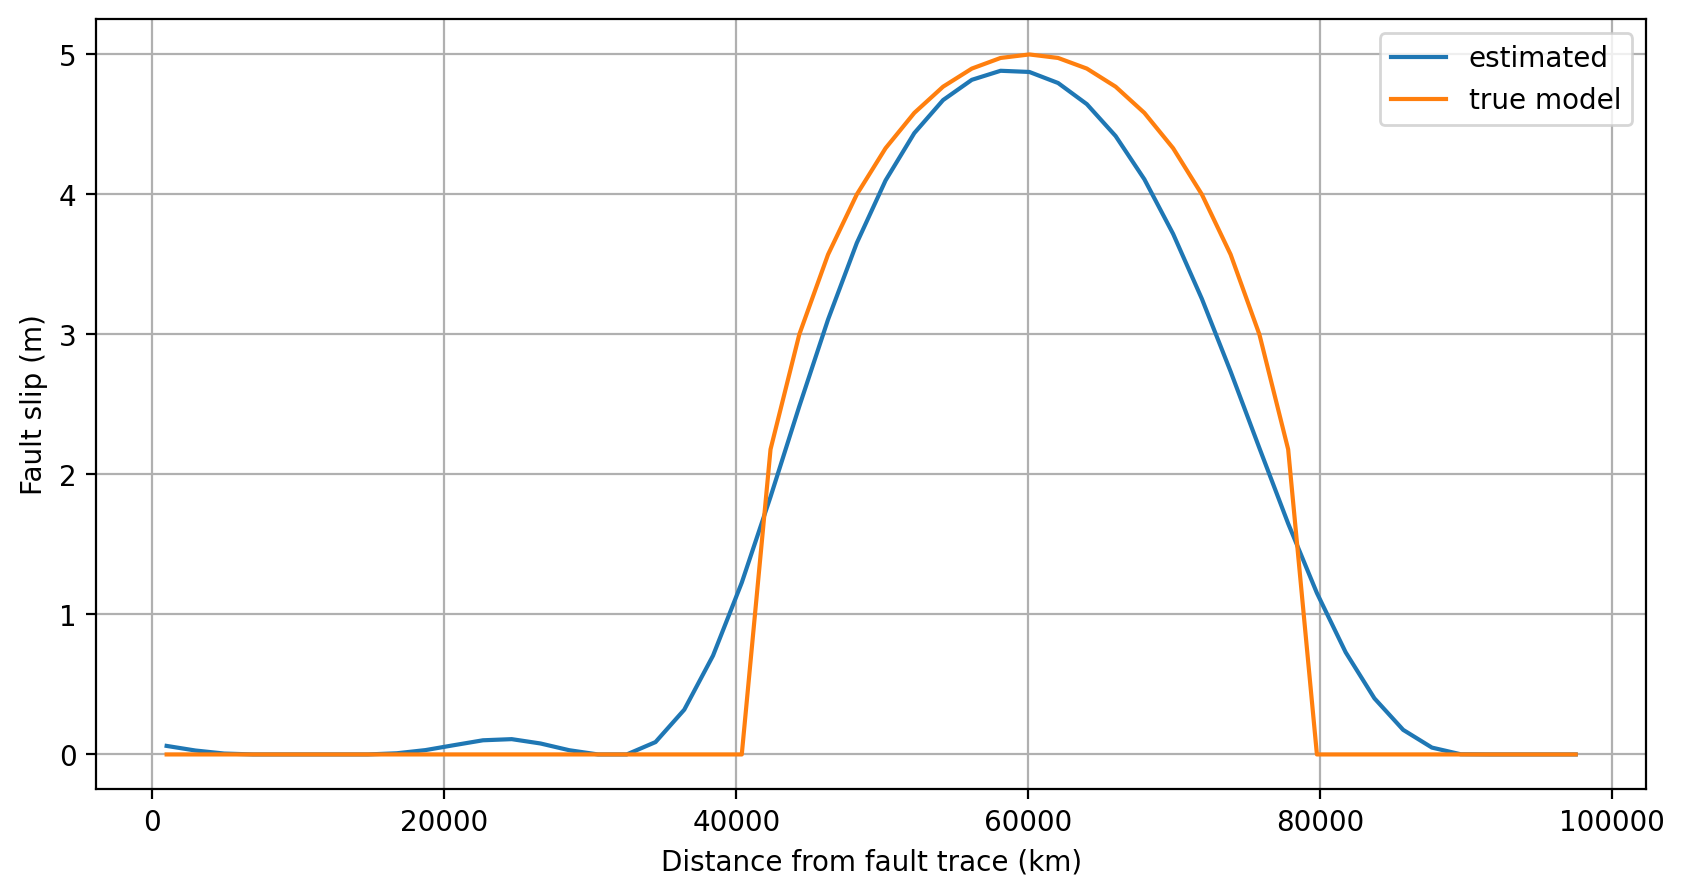

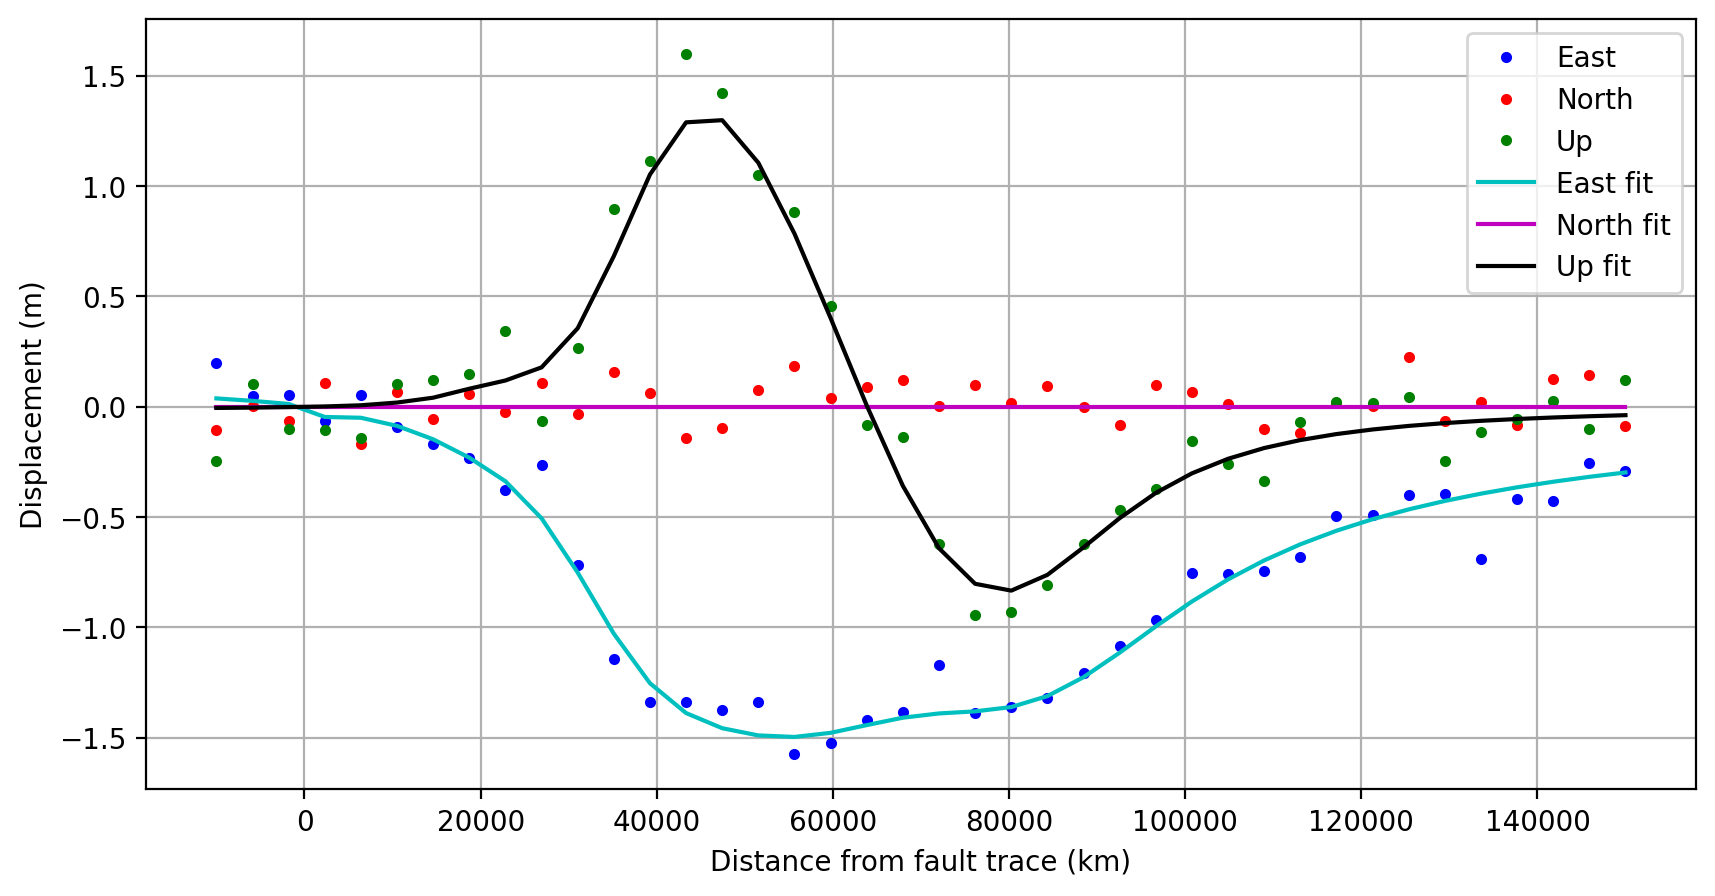

In [162]:
# The bounded model is much closer than before, but we could still do better if the model was smoother. Let's add smoothing:
L = create_1d_laplacian(Npatches)

# smoothing factor
lam = 1

print('G shape:', np.shape(G))
print('L shape:', np.shape(L))
G_augmented = np.row_stack( (G, lam*L) )
print('G_aug shape:', np.shape(G_augmented))

# we also need to augment the data vector with zeros
print('Data shape:', np.shape(noisydata))
d_augmented = np.concatenate( (noisydata,np.zeros(Npatches)), axis=None)
print('Data_aug shape:', np.shape(d_augmented))

mfit_smooth = scipy.optimize.lsq_linear(G_augmented,d_augmented,bounds = (model_min,model_max))



# plot the synthetic model slip
plt.figure(figsize=(10,5))
plt.plot(patchx,mfit_smooth.x,label='estimated')
plt.plot(patchx,dip_slip,label='true model')
plt.xlabel('Distance from fault trace (km)')
plt.ylabel('Fault slip (m)')
plt.grid()
plt.legend()
plt.show()

# plot the fit to the data
data_fit = np.matmul(G,mfit_smooth.x)

plt.figure(figsize=(10,5))
plt.plot(gpsx,data_E,'b.',label='East')
plt.plot(gpsx,data_N,'r.',label='North')
plt.plot(gpsx,data_U,'g.',label='Up')
plt.plot(gpsx,data_fit[0::3],'-c',label='East fit')
plt.plot(gpsx,data_fit[1::3],'-m',label='North fit')
plt.plot(gpsx,data_fit[2::3],'-k',label='Up fit')
plt.xlabel('Distance from fault trace (km)')
plt.ylabel('Displacement (m)')
plt.legend(loc='upper right')
plt.grid()
plt.show()


## Your turn: finding the optimal model

Try computing the Chi-squared misfit between the noisy data and the model predictions. You can use 'noiseamp' as the uncertainty. 

Then, run the model several times with different smoothing, and plot the misfit as a function of the smoothing value, and choose the 'best' one. 